# TP 1 (Tomas Palazzo, Noe Hsueh, Axel Fridman)

### Importacion de librerias

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import pandas as pd
import pickle
import time
import math
import seaborn as sns


In [5]:
import sys
from google.colab import drive

In [6]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Funciones auxiliares

In [7]:
def derivadaEn1Punto1coordenada(f,Xs, x, h=0.01):
  extra = np.zeros(len(Xs))
  extra[x]=1
  return((f(Xs+extra*h)-f(Xs-extra*h))/(2*h))

In [8]:
def gradiente(f,Xs, h=0.01):
  df = np.zeros(len(Xs))
  for i in range(0, len(Xs)):
    df[i]= derivadaEn1Punto1coordenada(f,Xs, i, h)
  return(df)

In [9]:
def hessiano(f, xs, h=0.01):
    hes = np.zeros((len(xs), len(xs)))
    for i in range(0,len(xs)):
        for j in range(0, len(xs)):
            extra = np.zeros(len(xs))
            extra[i] = 1
            grad1 = derivadaEn1Punto1coordenada(f, xs+extra*h, j)
            

            grad2 = derivadaEn1Punto1coordenada(f, xs-extra*h, j)

            hes[i,j] = ((grad1-grad2)/(2*h))
           
    return (hes)

In [10]:
def seccionAurea(f, x, d, epsilon, p ):
    theta1 = (3- math.sqrt(5))/2
    theta2 = 1 - theta1
    a = 0
    s = p
    b = 2*p
    phiB = f(x+ b*d)
    phiS = f(x+ s*d)
    while(phiB<phiS):
        a = s
        s = b
        b = 2*b
        phiS = phiB
        phiB = f(x + b * d)
    u = a + theta1 * (b-a)
    v = a + theta2 * (b-a)
    phiU = f(x + u*d)
    phiV = f(x + v*d)
    while((b-a)>epsilon):
        if(phiU<phiV):
            b = v
            v = u
            u = a + theta1*(b-a)
            phiV = phiU
            phiU = f(x + u * d)
        else:
            a = u
            u = v
            v = a + theta2*(b-a)
            phiU = phiV
            phiV = f(x + v * d)
    return((u+v)/2)
            

### Funciones gradiente (normal, no conjugado)

In [146]:
def metodo_gradienteCuadraticas(A, b, x_0, max_iter, l=0):
  k = 0
  x = x_0
  d = -A @ x_0 - b
  while((k <= max_iter) and (np.linalg.norm(d) > 10e-6)):
    if l == 0:
     l = np.random.rand()
    t = l*((d.T @ d)/(d.T @ A @ d))
    x += t*d
    d = -A@x - b
    k = k +  1
  if(k==max_iter):
    print("ALCANZO MAX ITERACION!")
  return x, k 


In [12]:
def metodo_gradienteGenerico(f, x0, epsilon=0.001, maxiter=10000, n=0.4, beta=5): 
  precision = epsilon
  iter = 0
  x = x0
  xs = [x]
  
  grad = gradiente(f, x, epsilon)
  ds = [-1*grad]
  while(np.linalg.norm(grad)>precision and iter<maxiter):
      d = -1*grad
      t = busquedaArmijo(f, x, d, n, beta )
      x = x+t*d
      grad = gradiente(f, x, epsilon)
      iter = iter + 1
      xs.append(x)
      ds.append(-1*grad)
  if(iter==maxiter):
    print("ALCANZO MAX ITERACION!")
  return xs, ds , iter

### Metodos de gradiente conjugado

In [13]:
def metodo_gradienteConjugadoCuadraticas(A, b, x0, epsilon=0.001, maxiter=10000): 
  precision = epsilon
  iter = 0
  x = x0
  xs = [x]
  d = -(A@x0+b)
  ds = [d]
  while(np.linalg.norm(A@x+b)>precision and iter<maxiter):
      t = -((A@x+b).T@d) / (d.T@A@d)
      x = x+t*d
      bk = (d.T@A@(A@x+b)) / (d.T@A@d)
      d = -(A@x+b) + bk*d
      
      iter = iter + 1
      xs.append(x)
      ds.append(d)
  if(iter==maxiter):
    print("ALCANZO MAX ITERACION!")
  return xs[len(xs)-1] , iter, xs

In [14]:
def metodo_gradienteConjugadoGenerico(f, x0, epsilon=0.01, maxiter=10000): 
  precision = epsilon
  iter = 0
  x = x0
  xs = [x]
  grad = gradiente(f, x, 10**-5)
  d = -1*grad
  ds = [-1*grad]
  while(np.linalg.norm(grad)>precision and iter<maxiter):
      
      t = seccionAurea(f, x, d, 10**-5, 1)
      x = x+t*d
      if((iter+1) % len(x0) != 0):
        xant = xs[-1]
        bk = (gradiente(f,x).T @ gradiente(f,x)) / (gradiente(f,xant).T @ gradiente(f,xant))
      else:
        bk = 0
      d = -1* gradiente(f, x) + bk * d
      grad = gradiente(f, x, epsilon)
      iter = iter + 1
      xs.append(x)
      ds.append(d)
  if(iter==maxiter):
    print("ALCANZO MAX ITERACION!")
  return xs[-1] , iter, xs

### Metodos de newton

In [15]:
def newtonParaCuadraticas(A, b, x0, eps, maxIter):
    iter = 0
    x = x0
    dk = A@x0+b
    xs = [x]
    while(np.linalg.norm(dk)>eps and iter<maxIter):
        dk = np.linalg.solve(A, -(A@x+b))
        x = x + dk
        iter = iter + 1
        xs.append(x)
    return(x, iter, xs)

In [16]:
def newtonConModificacionLevenbergMarquardt(f, x0, gamma, eps = 0.01, maxIter=1000):
  iter = 0
  x = x0
  xs = [x]
  grad = gradiente(f, x, 10**-5)
  while(np.linalg.norm(grad)>eps and iter<maxIter):
    grad = gradiente(f, x, 10**-5)
    B = hessiano(f, x, 10**-5)
    u = min(np.linalg.eigvals(B))
    if(u<=0):
      B = B + (-u + gamma)*np.identity(len(B))
    dk = np.linalg.solve(B, -grad)
    tk = seccionAurea(f, x, dk, 10**-5, 1)
    x = x + dk*tk
    xs.append(x)
    iter = iter + 1
  return(x, iter, xs)

### Metodos de cuasi newton

In [17]:
def cuasiNewtonParaCuadraticas(A, b, x0, h0, eps, maxIter):
    itera = 0
    xViejo = x0
    hk = h0
    dkViejo = A@xViejo+b
    xs = [xViejo]
    while(np.linalg.norm(dkViejo)>eps and itera<maxIter):
        dkNuevo = A@xViejo+b
        dkNuevo = -hk@dkNuevo 
        tk =  (dkNuevo @ dkNuevo.T)/(dkNuevo.T@A@dkNuevo)
        xNuevo = xViejo + dkNuevo * tk
        sk = (xNuevo - xViejo)
        yk = A@sk
        hk = metodoDFP(hk, sk, yk) #cheqear si broyden es lo mejor
                                      
        itera = itera + 1
        xs.append(xNuevo)
        
        xViejo = xNuevo
        dkViejo = dkNuevo
    return(xViejo, itera, xs)

In [18]:
def broydenMala(hk, sk, yk):
    res = hk + (np.outer((sk-hk@yk),(sk-hk@yk).T)) / (yk.T@(sk-hk@yk))
    return res

In [19]:
def metodoDFP(hk, sk, yk):
    res = hk + (np.outer(sk,sk.T))/(yk.T@sk)
    res = res -  (hk@np.outer(yk,(yk.T))@hk)/(yk.T@ hk@yk)
    return res

In [20]:
def metodoBFGS(hk, sk, yk):
    res = hk + (1+(yk.T@hk@yk)/(sk.T@yk)) * (sk@sk.T)/(sk.T@yk)
    res = res - ((sk @ (yk.T) @ hk) + hk@yk@(sk.T))/(sk.T@yk)
    return res

## Cargar los archivos con las matrices generadas por nosotros previamente

In [23]:
pick_read = open('/content/gdrive/MyDrive/UBA/invop/tps/matrices.pkl','rb')
mats = pickle.load(pick_read)
pick_read.close()

In [24]:
df = pd.read_csv('/content/gdrive/MyDrive/UBA/invop/tps/infos.csv')

In [26]:
df["mat"] = mats.values()

In [27]:
df.head()

,Unnamed: 0,tamanio,autovalores,autovalorMax,autovalorMin,rangoAutovalores,mat
0,0,"(2, 2)",[2.13039600e+00 1.53733452e-04],2.130396,0.000154,2.130242,"[[1.4277800159666887, 1.0015353443246913], [1...."
1,1,"(2, 2)",[5.0753714 0.10702353],5.075371,0.107024,4.968348,"[[3.1084677041108315, 2.4297225441430976], [2...."
2,2,"(2, 2)",[8.90007051 1.18815833],8.900071,1.188158,7.711912,"[[6.319120032244062, 3.6390600481153315], [3.6..."
3,3,"(2, 2)",[5.48386614e+00 3.73334809e-04],5.483866,0.000373,5.483493,"[[5.203384950030568, 1.2080343186411266], [1.2..."
4,4,"(2, 2)",[12.15494409 24.71610474],24.716105,12.154944,12.561161,"[[16.76994508395115, 6.055702662291634], [6.05..."


Ejercicio 1

```

```



In [248]:
maxIters = 180000
zero = np.zeros(10)
unos = np.ones(10)
tamaniosPaso = [1/4, 1/2, 3/4, 0.99, 0.999, 1, 0] #0 es la version numero aleatorio entre 0 y 1
resultadosIter = []
tiempos =  []
pasos = []
rangoAutovals = []
for j in range(0, len(tamaniosPaso)):
  for i in range(0, len(mats10por10)):
    s = time.time()
    x, iter = metodo_gradienteCuadraticas(mats10por10["mat"][i+400],zero, 1*unos, maxIters, tamaniosPaso[j])
    pasos.append(tamaniosPaso[j])
    resultadosIter.append(iter)
    tiempos.append(time.time()-s)
    rangoAutovals.append(mats10por10["rangoAutovalores"][i+400])

In [249]:
res = {'rangoAutovalores': rangoAutovals, 'pasos': pasos,'iters': resultadosIter, "tiempo":tiempos}
dfResEj1 = pd.DataFrame(data=res)

In [241]:
max(dfResEj1.iters)

80001

Text(0, 0.5, 'Tiempo en segundos')

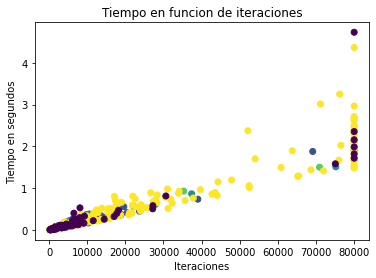

In [246]:
plt.scatter(dfResEj1['iters'], dfResEj1['tiempo'], c=dfResEj1['pasos'], label=dfResEj1['pasos'])

plt.title("Tiempo en funcion de iteraciones")
plt.xlabel("Iteraciones")
plt.ylabel("Tiempo en segundos")

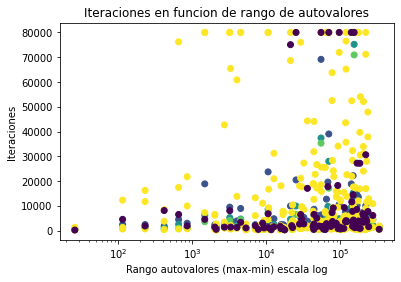

In [245]:
plt.scatter(dfResEj1['rangoAutovalores'], dfResEj1['iters'], c=dfResEj1['pasos'])
plt.title("Iteraciones en funcion de rango de autovalores")
plt.xlabel("Rango autovalores (max-min) escala log")
plt.ylabel("Iteraciones")
plt.xscale("log")

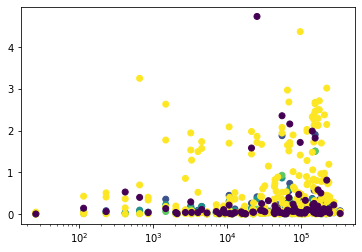

In [247]:
plt.scatter(dfResEj1['rangoAutovalores'], dfResEj1['tiempo'], c=dfResEj1['pasos'])
plt.xscale("log")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.



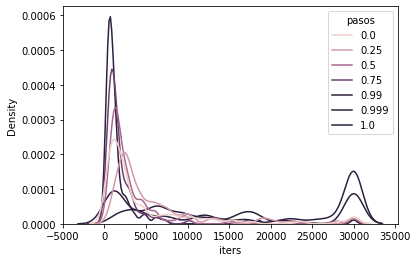

In [155]:
sns.kdeplot(data=dfResEj1, x='iters', hue='pasos', common_norm= False, bw=0.1)

In [250]:
from google.colab import files
dfResEj1.to_csv('dfResEj1.csv') 
files.download('dfResEj1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>